In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from zipfile import ZipFile
import os
from os import path
import shutil

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
url = '/content/drive/MyDrive/dataset/'

Mounted at /content/drive


In [ ]:
dataset_C = url + 'Dataset C.zip'
with ZipFile(dataset_C, 'r') as zip:
  zip.extractall()

In [ ]:
PATH = '/content/'
data_labels = pd.read_csv(PATH + 'training-c.csv', usecols = ['filename', 'digit'])
print(data_labels.shape)
data_labels.head()

(24298, 2)


,filename,digit
0,c00000.png,6
1,c00001.png,1
2,c00002.png,3
3,c00003.png,2
4,c00004.png,7


In [ ]:
TRAIN_PATH = url + 'Classify numbers'

In [ ]:
os.mkdir(TRAIN_PATH)

def processImages(folder_name):
  src = PATH + folder_name + '/'
  dir_folders = os.listdir(src)
  for dir_name in dir_folders:
    file_name = os.path.join(src, dir_name)
    if os.path.isfile(file_name):
      shutil.copy(file_name, TRAIN_PATH) 

processImages('training-c')

In [ ]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [ ]:
mean = [0.5,]
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

train_data  = Dataset(data_labels, TRAIN_PATH, train_transform)
test_data = Dataset(data_labels, TRAIN_PATH, test_transform)

print("Trainig Samples: ", len(train_data))

Trainig Samples:  24298


# **Experiment 2**

In [ ]:
#Batch Parameters
batch_size = 100
num_iters = 20000
input_dim = 28*28
num_hidden = 100
output_dim = 10

learning_rate = 0.001

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

82


In [ ]:
test_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
train_idx, test_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:195
Test dataloader:49


In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()

       #First Hidden Layer
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 = nn.ReLU()

        #2nd Hidden Layer
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.Tanh()

         #3rd Hidden Layer
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.relu_3 = nn.Tanh()

         #4th Hidden Layer
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.relu_4 = nn.Softmax(dim=0)

        #  #5th Hidden Layer
        # self.linear_5= nn.Linear(num_hidden, num_hidden)
        # self.relu_5= nn.Tanh()
        
        # #6th Hidden Layer
        # self.linear_6 = nn.Linear(num_hidden, num_hidden)
        # self.relu_6 = nn.Tanh()


 
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)
 
        out  = self.linear_3(out)
        out = self.relu_3(out)
 
        out  = self.linear_4(out)
        out = self.relu_4(out)
 
        # out  = self.linear_5(out)
        # out = self.relu_5(out)
 
        # out  = self.linear_6(out)
        # out = self.relu_6(out)


        
        
        probas  = self.linear_out(out)
        return probas

In [ ]:
model = DeepNeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_hidden)
model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=100, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=100, out_features=100, bias=True)
  (relu_2): Tanh()
  (linear_3): Linear(in_features=100, out_features=100, bias=True)
  (relu_3): Tanh()
  (linear_4): Linear(in_features=100, out_features=100, bias=True)
  (relu_4): Softmax(dim=0)
  (linear_out): Linear(in_features=100, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    print('Epoch: ', epoch + 1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images) 

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:        
            correct = 0
            total = 0
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Epoch:  1
Epoch:  2
Epoch:  3
Iteration: 500. Loss: 2.2354726791381836. Accuracy: 18.831035192426427
Epoch:  4
Epoch:  5
Epoch:  6
Iteration: 1000. Loss: 2.064074993133545. Accuracy: 26.589833299032723
Epoch:  7
Epoch:  8
Iteration: 1500. Loss: 1.9832240343093872. Accuracy: 27.989298209508128
Epoch:  9
Epoch:  10
Epoch:  11
Iteration: 2000. Loss: 1.9765340089797974. Accuracy: 29.51224531796666
Epoch:  12
Epoch:  13
Iteration: 2500. Loss: 1.907224416732788. Accuracy: 29.26528092200041
Epoch:  14
Epoch:  15
Epoch:  16
Iteration: 3000. Loss: 1.9222133159637451. Accuracy: 29.368182753653016
Epoch:  17
Epoch:  18
Iteration: 3500. Loss: 2.0865371227264404. Accuracy: 30.41778143650957
Epoch:  19
Epoch:  20
Epoch:  21
Iteration: 4000. Loss: 1.7422126531600952. Accuracy: 31.32331755505248
Epoch:  22
Epoch:  23
Epoch:  24
Iteration: 4500. Loss: 1.7771310806274414. Accuracy: 34.51327433628319
Epoch:  25
Epoch:  26
Iteration: 5000. Loss: 1.8643252849578857. Accuracy: 35.33648898950401
Epoch:  27
E

[2.2354726791381836, 2.064074993133545, 1.9832240343093872, 1.9765340089797974, 1.907224416732788, 1.9222133159637451, 2.0865371227264404, 1.7422126531600952, 1.7771310806274414, 1.8643252849578857, 1.810043454170227, 1.8611745834350586, 1.7566757202148438, 1.7071903944015503, 1.714668869972229, 1.5962833166122437, 1.6280279159545898, 1.5612317323684692, 1.4404290914535522, 1.5081350803375244, 1.3663979768753052, 1.3134446144104004, 1.2197321653366089, 1.4061408042907715, 1.2965147495269775, 1.2832353115081787, 1.157793402671814, 1.2778902053833008, 1.2468066215515137, 1.1584131717681885, 1.1759659051895142]


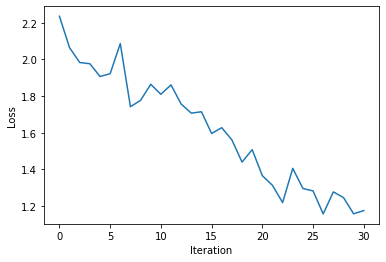

In [ ]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()